In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install shap
#!pip install dtale
#!pip install git+https://github.com/Danyleb/Lstm-Variational-Auto-encoder.git

In [ ]:
#import sys
#sys.path.append('/content/drive/MyDrive/vde')
#sys.path.append('/content/drive/MyDrive/msmbuilder')
#sys.path.append('/content/drive/MyDrive/LstmVAE')

In [ ]:
#import msmbuilder
#from vde import VDE
#from LstmVAE import LSTM_Var_Autoencoder

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [ ]:
visible = Input(shape = (n_inputs,))
#Define Encoder
#level 1
e = Dense(n_inputs*2)(visible) # e = encoder
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# level 2 
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

#Bottleneck 
n_bottleneck = round(float(n_inputs)/2.0)
bottleneck = Dense(n_bottleneck)(e)

# Define Decoder
#level 1
d = Dense(n_inputs)(bottleneck) # d = dencoder
d = BatchNormalization()(d)
d = LeakyReLU()(d)

#level 2
d = Dense(n_inputs*2)(d) # d = dencoder
d = BatchNormalization()(d)
d = LeakyReLU()(d)

#Output layer
output = Dense(n_inputs, activation = 'linear')(d)

#Define autoencoder model
model = Model(inputs = visible, outputs = output)

#compile autoencoder
model.compile(optimizer = 'adam', loss = 'mse')

plot_model(model, 'autoencoder_compress.png', show_shapes = True)

In [ ]:
import pandas as pd
import numpy as np
#import dtale


df1 = pd.read_csv('/content/drive/MyDrive/HFT project1/lob_feature3.csv')
df2 = pd.read_csv('/content/drive/MyDrive/HFT project1/lob_feature2.csv')
df3 = pd.read_csv('/content/drive/MyDrive/HFT project1/lob_feature1.csv')
df4 = pd.read_csv('/content/drive/MyDrive/HFT project1/feature1_footprint.csv')
df5 = pd.read_csv('/content/drive/MyDrive/HFT project1/feature2 TA.csv')
df6 = pd.read_csv('/content/drive/MyDrive/HFT project1/feature2 TA2.csv')
df7 = pd.read_csv('/content/drive/MyDrive/HFT project1/feature3 MA.csv')

X = pd.concat([df1,df2,df3,df4,df5,df6,df7], axis=1)
X = X.drop(labels = range(0,200), axis=0)

Y = pd.read_csv('/content/drive/MyDrive/label 0.0001 10.csv')
Y = Y.drop(labels = range(0,200), axis=0)


#dtale.show(X)
#dtale.show(Y)


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split

X = np.array(X)
X = X.astype(np.float64)
Y = np.array(Y)

#trainX, testX, trainY, testY = train_test_split(X, Y, test_size= 0.3, shuffle = False)

tss = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tss.split(X):
  train_X, test_X = X[train_index], X[test_index]
  trainY, testY = Y[train_index], Y[test_index]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))


train_X = np.nan_to_num(train_X)
test_X = np.nan_to_num(test_X)

train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

print(train_X)
print(test_X)

In [ ]:
#vde_model = VDE(test_X[0].shape[-1], lag_time=10, hidden_layer_depth=3, sliding_window=True, n_epochs=100, learning_rate=0.001, batch_size=256)
#latent_output = vde_model.fit_transform(test_X)

In [ ]:
#vae = LSTM_Var_Autoencoder(intermediate_dim=50, z_dim=50, n_dim=train_X[0].shape[-1], stateful=True)
#vae.fit(train_X, learning_rate=0.001, batch_size=128, num_epochs=200, opt=tf.optimizers.Adam(), REG_LAMBDA=0.01)
#x_reconstructed, recons_error = vae.reconstruct(train_X, get_error=True)
#x_reduced = vae.reduce(train_X)

In [ ]:
# Fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs = 200, batch_size = 16, verbose = 2, validation_data = (X_test,X_test))

In [ ]:
#Plot Loss
fig, ax = plt.subplots(figsize=(10,5)) 
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.title('Autoencoder loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Autoencoderloss.png')

In [ ]:
#Define an encoder model without the decoder
encoder = Model(inputs =visible, outputs = bottleneck)
plot_model(model, 'encoder_compress.png', show_shapes = True)

# Save model
encoder.save('encoder.h5')

In [ ]:
# load the model from file
encoder = load_model('encoder.h5')

# encode the  data
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
    
train_X =  pca.fit_transform(train_X)
test_X = pca.transform(test_X)

#from sklearn.manifold import TSNE

#tsne = TSNE(n_components=100, perplexity=50, learning_rate='auto', method='exact')

#train_X = tsne.fit_transform(trainX)
#test_X =tsne.fit_transform(testX)


print(train_X)
print(test_X)


In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

clf = lgb.LGBMClassifier()

clf.fit(train_X, trainY.ravel())

test = clf.predict(test_X)
print(accuracy_score(testY, test))


0.6057239224244829


In [ ]:
test2 = clf.predict(train_X)
print(accuracy_score(trainY, test2))

0.7221213254277727


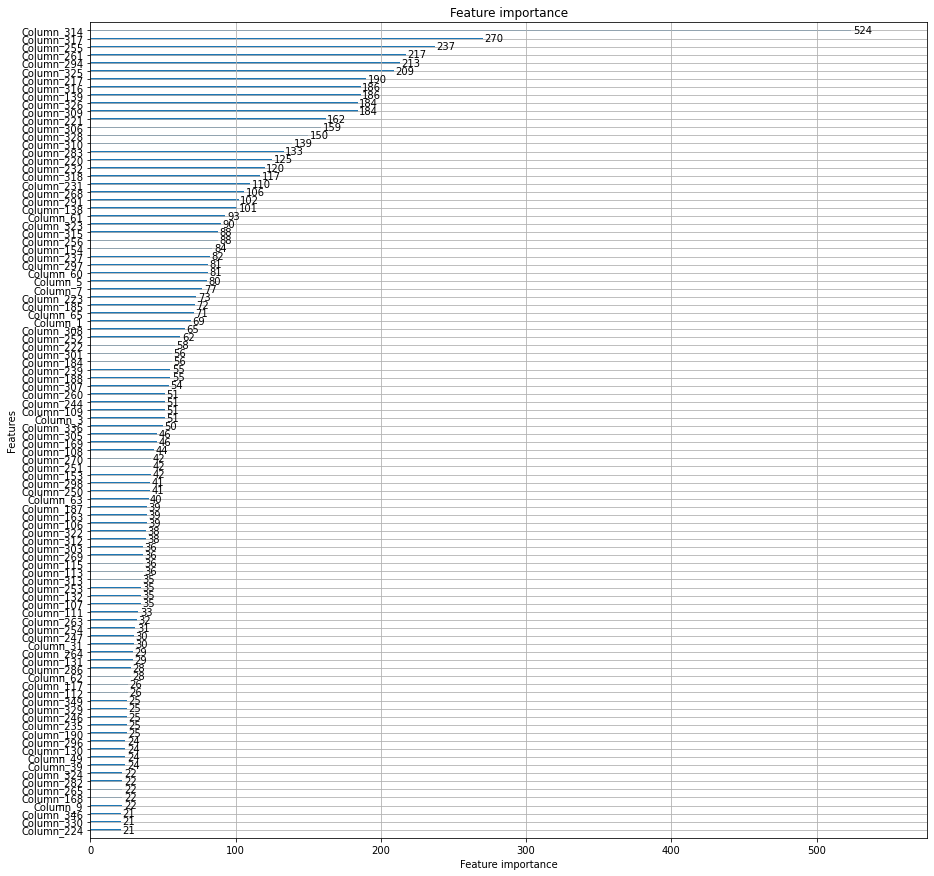

In [ ]:
lgb.plot_importance(clf, max_num_features=100, figsize=(15,15))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


RF = RandomForestClassifier(n_estimators=5000, max_leaf_nodes=100, n_jobs=-1)

RF.fit(train_X, trainY.ravel())

test = RF.predict(test_X)
print(accuracy_score(testY, test))

0.566092951738505


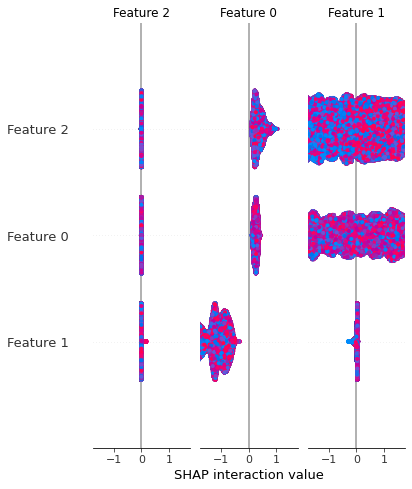

In [ ]:
import shap

explainer = shap.Explainer(clf)

shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X)

In [ ]:
backtestX = np.vstack((train_X, test_X))

signal=  clf.predict(backtestX)
signal = pd.DataFrame(signal)
print(accuracy_score(Y, signal))


0.6930220579468225


In [ ]:
import dtale

dtale.app.USE_COLAB = True
dtale.show(signal)

In [ ]:
signal.to_csv('/content/drive/MyDrive/signal5.csv')

In [ ]:
print(signal)

         0
0        0
1        0
2       -1
3        0
4        0
...     ..
1048370 -1
1048371 -1
1048372 -1
1048373 -1
1048374  0

[1048375 rows x 1 columns]


In [ ]:
bid_price = pd.DataFrame(X).iloc[:, 2]
bid_price = pd.DataFrame(bid_price)

print(bid_price)

               2
0        4772.25
1        4772.00
2        4772.00
3        4771.75
4        4771.75
...          ...
1048370  4431.50
1048371  4431.00
1048372  4431.25
1048373  4431.25
1048374  4431.50

[1048375 rows x 1 columns]


In [ ]:
prices = pd.concat([bid_price, bid_price, bid_price, bid_price, signal, signal], axis=1)
prices.columns=['open','high','low','close','volume','predicted']
prices['volume'] = 0
print(prices)

            open     high      low    close  volume  predicted
0        4772.25  4772.25  4772.25  4772.25       0         -1
1        4772.00  4772.00  4772.00  4772.00       0         -1
2        4772.00  4772.00  4772.00  4772.00       0         -1
3        4771.75  4771.75  4771.75  4771.75       0         -1
4        4771.75  4771.75  4771.75  4771.75       0         -1
...          ...      ...      ...      ...     ...        ...
1048370  4431.50  4431.50  4431.50  4431.50       0         -1
1048371  4431.00  4431.00  4431.00  4431.00       0         -1
1048372  4431.25  4431.25  4431.25  4431.25       0         -1
1048373  4431.25  4431.25  4431.25  4431.25       0         -1
1048374  4431.50  4431.50  4431.50  4431.50       0          1

[1048375 rows x 6 columns]


In [ ]:
prices.to_csv('/content/drive/MyDrive/prices')